## 实验十五：TS算法求解P-中值模型

In [244]:
import math
import random 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
import time
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示不乱码

In [245]:
def get_data():
    
    DemandLocation = [(88, 16),(25, 76),(69, 13),(73, 56),(80, 100),(22, 92),(32, 84),(73, 46),(29, 10),(92, 32),(44, 44),(55, 26),(71, 27),(51, 91),(89, 54),(43, 28),(40, 78)]
    CenterLocation = [(32, 60),(69, 33),(49, 40),(72, 81),(61, 65)]
    d = [3,4,5,6,7,4,2,3,4,5,6,3,5,4,3,5,1]#需求量
    c = [25,25,25,25,25]#仓库容量设置
    c_name = ['A','B','C','D','E'] # 仓库名称
    p = 3 #待决策物流中心数量
    demand_num = int(len(DemandLocation)) #需求点数量
    cargo_num = int(len(CenterLocation)) #备选中心数量
    
    # 计算中心与需求点之间的距离，生成距离函数
    dist_matrix = pd.DataFrame(data=None,columns=range(cargo_num),index=range(demand_num))
    for i in range(demand_num):
        xi,yi = DemandLocation[i][0],DemandLocation[i][1]
        for j in range(len(CenterLocation)):
            xj,yj = CenterLocation[j][0],CenterLocation[j][1]
            dist_matrix.iloc[i,j] = round(math.sqrt((xi-xj)**2+(yi-yj)**2),2)
    
    return DemandLocation,CenterLocation,d,c,p,demand_num,cargo_num,dist_matrix,c_name

In [246]:
# 编码、初始解产生方式
def initialize(demand_num, cargo_num, p):
    """
    in:demand_num-需求点数量，cargo_num-备选点数量，p-要开设的设施数量
    out:染色体
    """
    clist = random.sample(range(cargo_num),p)
    cargo_chrom = [1 if i in clist else 0 for i in range(cargo_num)]
    demand_chrom = [random.choices(range(1,p+1))[0] for i in range(demand_num)]
    chrom = cargo_chrom + demand_chrom
    
    return chrom

In [247]:
# 计算路径距离，即评价函数calFitness()
def calFitness(chrom, dist_matrix, cargo_num, d, c):
## 输入: chrom-染色体，dist_matrix -距离矩阵，cargo_num-备选点数量，d -需求数组，c-备选仓库数组
## 输出: dis_sum -总距离
    # 初始化数据
    dis_sum=0
    pick = [] # 存储被选中点
    chrom_copy =chrom.copy()
    demand_list = [[] for i in range(cargo_num)]# 存储备选点的需求点list
    weight = [0 for i in range(cargo_num)]# 存储备选点的总权重
    demand = [0 for i in range(cargo_num)]# 存储备选点的总需求
    
    # 筛选被选中的点
    for i in range(cargo_num):
        if chrom[i] == 1:
            pick.append(i)
    
    # 遍历所有需求点
    for i in range(cargo_num,len(chrom_copy)): 
        demand_index=i-cargo_num
        chrom_copy[i] = pick[chrom_copy[i]-1]#？
        demand_list[chrom_copy[i]].append(demand_index)#？
        weight[chrom_copy[i]] += dist_matrix.loc[demand_index,chrom_copy[i]]*d[demand_index] #加权距离，累加
        demand[chrom_copy[i]] += d[demand_index]
    
    
    flag = 0
    for i in range(len(demand)):
        if demand[i] > c[i]:
            dis_sum = math.pow(10,10)
            flag = 1
            break
    if flag == 0:
        dis_sum = round(sum(weight),1)
        
    return dis_sum


In [248]:
def traversal_search(chrom,dist_matrix,tabu_list, cargo_num, d, c, p):
    #邻域随机遍历搜索，成对交换+单点变异
    traversal = 0 #搜索次数
    traversal_list = [] #存储局部搜索生成的解,也充当局部禁忌表
    traversal_value = [] #存储局部解对应路径距离
    while traversal <= traversalMax:
        new_chrom = chrom.copy()#复制当前路径，并交换生成新路径
        pos1,pos2 = random.randint(0, cargo_num-1),random.randint(0, cargo_num-1)#交换点
        new_chrom[pos1],new_chrom[pos2]=new_chrom[pos2],new_chrom[pos1]
        
        pos1,pos2 = random.randint(cargo_num,len(chrom)-1),random.randint(cargo_num,len(chrom)-1)#交换点
        new_chrom[pos1],new_chrom[pos2]=new_chrom[pos2],new_chrom[pos1]
        
        for i in range(cargo_num,len(chrom)):
            if random.random() > 0.75:#一定概率改变
                new_chrom[i] = random.randint(1,p)
                
        new_value = calFitness(new_chrom,dist_matrix, cargo_num, d, c)#当前路径距离
        #新生成路径不在全局禁忌表和局部禁忌表中，为有效搜索，否则继续搜索
        if (new_chrom not in traversal_list) & (new_chrom not in tabu_list):
            traversal_list.append(new_chrom)
            traversal_value.append(new_value)
            traversal += 1
    
    return min(traversal_value),traversal_list[traversal_value.index(min(traversal_value))]

In [287]:
# 画散点图
def draw_scatter(Coordinates1,Coordinates2,labels):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    x1 = [i[0] for i in Coordinates1]
    y1 = [i[1] for i in Coordinates1]
    plt.scatter(x1, y1, color='#ff69E1', marker='o')

    x2 = [i[0] for i in Coordinates2]
    y2 = [i[1] for i in Coordinates2]
    plt.scatter(x2, y2, color='#4169E1', marker='*')

    # 对备选仓库点进行标注
    for (x, y), label in zip(zip(x2, y2), labels):
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(5,5), ha='center')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('仓库分配方案')
    plt.show()


In [288]:
# 画分布图
def draw_path(chrom, DemandLocation, CenterLocation, p, cargo_num,c_name):
    centerlist = []
    # 识别被选中的仓库点位置
    for i in range(cargo_num):
        if chrom[i] == 1:
            centerlist.append(CenterLocation[i])
    
    for i in range(cargo_num,len(chrom)):
        demand_index=i-cargo_num
        if chrom[i] == 1:
            plt.plot([centerlist[0][0],DemandLocation[demand_index][0]], 
                     [centerlist[0][1],DemandLocation[demand_index][1]], 'r-', color='#4169E1', alpha=0.8, linewidth=0.8)
        elif chrom[i] == 2:
            plt.plot([centerlist[1][0],DemandLocation[demand_index][0]], 
                     [centerlist[1][1],DemandLocation[demand_index][1]], 'r-', color='#4169E1', alpha=0.8, linewidth=0.8)
        elif chrom[i] == 3:
            plt.plot([centerlist[2][0],DemandLocation[demand_index][0]], 
                     [centerlist[2][1],DemandLocation[demand_index][1]], 'r-', color='#4169E1', alpha=0.8, linewidth=0.8)
    
    # 调用散点图函数
    draw_scatter(DemandLocation,CenterLocation,c_name)

初代最优值 2575.0
模型运行中
模型求解结束


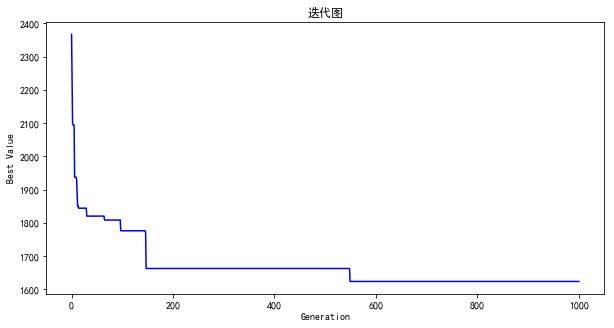

In [289]:
if __name__ == '__main__':
    
    start_time=time.time()
    
    # 数据初始化    
    ## TS参数
    """
    tabu_limit禁忌长度
    iterMax迭代次数
    traversalMax每一代局部搜索次数
    """
    tabu_limit = 100
    iterMax = 1000
    traversalMax = 100
    
    # 算法前置准备
    tabu_list = [] #禁忌表
    tabu_time = [] #禁忌次数
    best_value = math.pow(10,10)#较大的初始值，存储最优解
    best_line = []#存储最优路径
    
    # 模型数据导入
    DemandLocation,CenterLocation,d,c,p,demand_num,cargo_num,dist_matrix,c_name=get_data()
        
    # 初始化,随机构造
    num = 50
    chroms = [initialize(demand_num, cargo_num, p) for i in range(num)]
    values = [calFitness(chrom,dist_matrix, cargo_num, d, c) for chrom in chroms]
    
    best_value = min(values)
    best_chrom = chroms[values.index(best_value)]
    chrom,value = best_chrom,best_value
    # 存储当前最优
    print('初代最优值 %.1f' % (best_value))
    
    best_value_list = []
    best_value_list.append(best_value)
    generation_values = []  # 存储每代的最优解的目标值
    #更新禁忌表
    tabu_list.append(best_chrom)
    tabu_time.append(tabu_limit)
    
    itera = 0
    print('模型运行中')
    while itera <= iterMax:
        new_value,new_chrom = traversal_search(chrom,dist_matrix,tabu_list, cargo_num, d, c, p)
        if new_value < best_value:#优于最优解
            best_value,best_chrom = new_value,new_chrom#更新最优解
            best_value_list.append(best_value)
        #print('第%.d代最优值 %.1f' % (itera,best_value))
        chrom,value = new_chrom,new_value #更新当前解
        generation_values.append(best_value)  # 记录当前代的最优目标值
        
        #更新禁忌表
        tabu_time = [x-1 for x in tabu_time]
        if 0 in tabu_time:
            tabu_list.remove(tabu_list[tabu_time.index(0)])
            tabu_time.remove(0)
        
        tabu_list.append(chrom)
        tabu_time.append(tabu_limit)
        itera +=1
        
       
    end_time = time.time()
    print('模型求解结束')                

    # 绘制折线图
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(generation_values)), generation_values, linestyle='-', color='b')
    plt.title('迭代图')
    plt.xlabel('Generation')
    plt.ylabel('Best Value')
    plt.show()

In [290]:
# 收集需求点的信息
results=[]
for demand_index in range(demand_num):
    assigned_warehouse = best_chrom[demand_index + cargo_num]
    demandpoint={
                #'Demand Index': demand_index,
                'Assigned Warehouse': c_name[assigned_warehouse],
                'Warehouse Location':CenterLocation[assigned_warehouse],
                'Demand Location': DemandLocation[demand_index],
                'Demand Quantity': d[demand_index]
            }
    results.append(demandpoint)               
df = pd.DataFrame(results)
                
warehouse_info = []
served_demand_points = []
for w in range(cargo_num):
    if best_chrom[w] == 1:
        total_demand_served = 0
        for di in range(cargo_num,len(best_chrom)):
            if best_chrom[di] == w:
                served_demand_points = []
                total_demand_served += d[di-5]
        warehouse_info.append({
        'Warehouse Name': c_name[w],
        'Warehouse Location':CenterLocation[w],
        'Total Demand Served':total_demand_served
    })      
df_warehouse = pd.DataFrame(warehouse_info)

模型求解时间:13.6s
模型最优解为: [0, 1, 1, 1, 0, 1, 2, 1, 3, 3, 3, 3, 1, 2, 1, 2, 2, 1, 3, 1, 2, 3]
模型最优值为: 1624.2


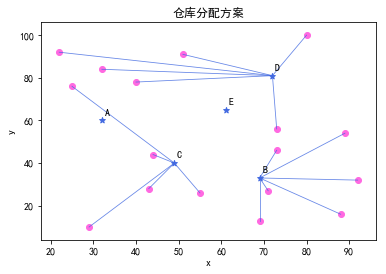

In [293]:
## 求解时间运算
time_diff = end_time - start_time
print("模型求解时间:{:.1f}s" .format(time_diff))
print('模型最优解为:',best_chrom)
print('模型最优值为:',best_value )

# 画图
draw_path(best_chrom, DemandLocation, CenterLocation, p, cargo_num, c_name)

writer = pd.ExcelWriter('optimization_results.xlsx')
df_warehouse.to_excel(writer,sheet_name='warehouse',index=False)
df.to_excel(writer, sheet_name='assignment',index=False)
writer.save()


In [292]:
warehouse_info

[{'Warehouse Name': 'B',
  'Warehouse Location': (69, 33),
  'Total Demand Served': 24},
 {'Warehouse Name': 'C',
  'Warehouse Location': (49, 40),
  'Total Demand Served': 22},
 {'Warehouse Name': 'D',
  'Warehouse Location': (72, 81),
  'Total Demand Served': 24}]